In [2]:
import sys
sys.path.append("../")
from matplotlib import pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from axessettings import AxesSetting, linear_sim

In [3]:
A0 = 10**(106/20)
wp = 2*np.pi*5
A = lambda s: A0/(1+s/wp)

In [4]:
def plot_bode(filename: str, fig = None, axes = None, name=None, argshift=None, legend=False, xlim=None):
    is_new = False
    if fig is None:
        is_new = True
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    df = pd.read_csv(filename, names=["f", "mag", "phase"], skiprows=1)
    axes[0].plot(df["f"], 20*np.log10(df["mag"]), label=name if name else filename)
    axes[1].plot(df["f"], argshift(df["phase"]) if argshift else df["phase"], label=name if name else filename)
    if is_new:
        axstg1 = AxesSetting(title="Magnitude", xlabel="f [Hz]", ylabel="Gain [dB]", xscale="log", legend=legend, grid="both", xlim=xlim)
        axstg1.apply_axes(axes[0])
        axstg2 = AxesSetting(title="Phase", xlabel="f [Hz]", ylabel="Phase [$^\circ$]", xscale="log", legend=legend, grid="both", xlim=xlim)
        axstg2.apply_axes(axes[1])
        fig.tight_layout()
        fig.suptitle(name if name else filename)
    return fig, axes

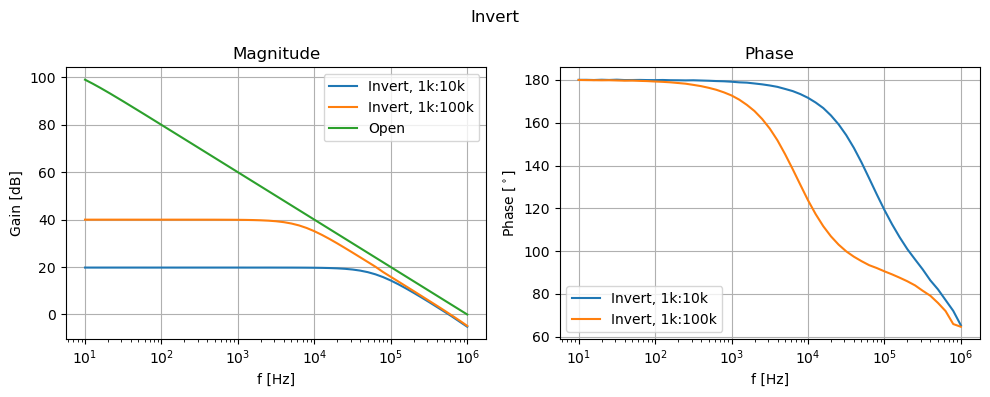

In [5]:
axstgs = [
    AxesSetting(title="Magnitude", xlabel="f [Hz]", ylabel="Gain [dB]", xscale="log", grid="both"),
    AxesSetting(title="Phase", xlabel="f [Hz]", ylabel="Phase [$^\circ$]", xscale="log", grid="both")
]
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("1_bode_invert_1k_10k.csv", fig, axes, name="Invert, 1k:10k", argshift=lambda x: x+360)
plot_bode("1_bode_invert_1k_100k.csv", fig, axes, name="Invert, 1k:100k")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(A(2j*np.pi*f))), label="Open", xlim=(1e1, 1e6))
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Invert")
fig.tight_layout()

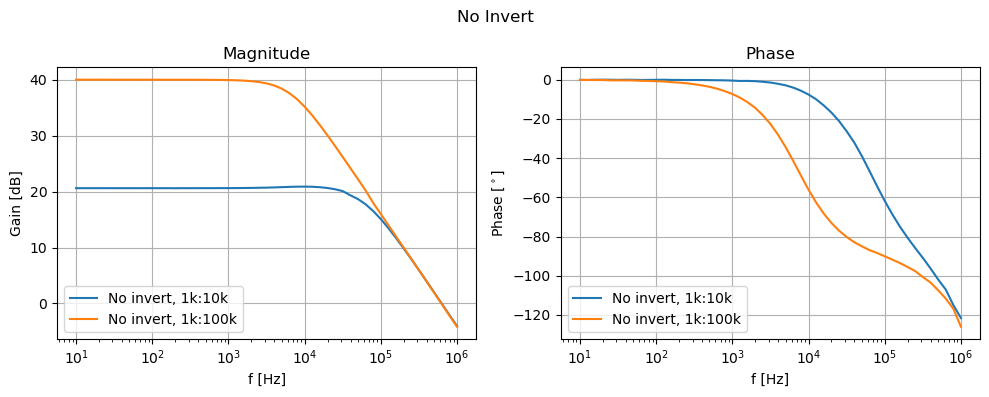

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("1_bode_noinvert_1k_10k.csv", fig, axes, name="No invert, 1k:10k")
plot_bode("1_bode_noinvert_1k_100k.csv", fig, axes, name="No invert, 1k:100k")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("No Invert")
fig.tight_layout()

In [7]:
def A_derv(s, Cf, Rf, Cr, Rr):
    return -s*Cr*Rf/(s*Cr*Rr + 1)/(s*Cf*Rf + 1)

Cf = 214e-12
Cr = 218.6e-9
Rr = 9.981e3
Rf = 99.09e3

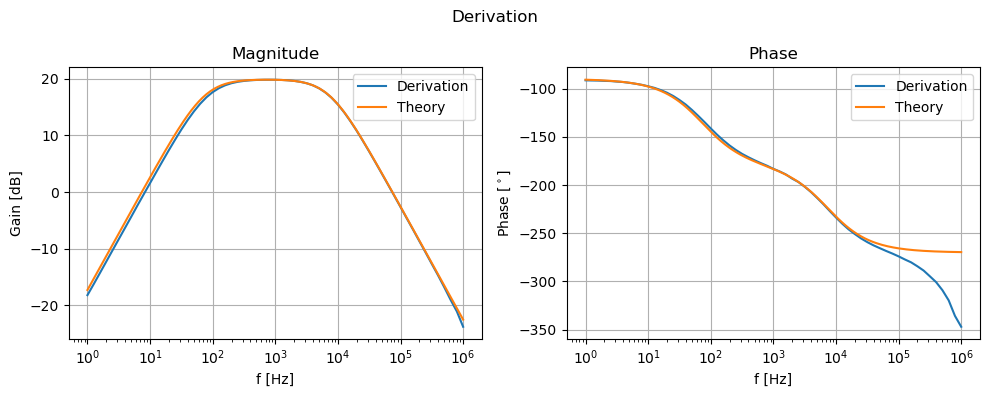

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("2_bode_derv.csv", fig, axes, name="Derivation")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(A_derv(2j*np.pi*f, Cf, Rf, Cr, Rr))), label="Theory", xlim=(1e0, 1e6))
axstgs[1].plot_func(axes[1], lambda f: (np.angle(A_derv(2j*np.pi*f, Cf, Rf, Cr, Rr), deg=True)+360)%360-360, label="Theory", xlim=(1e0, 1e6))
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Derivation")
fig.tight_layout()

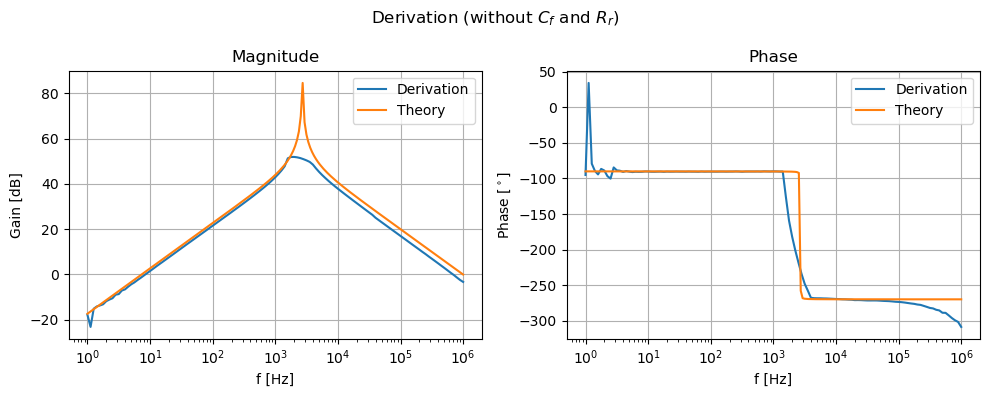

In [9]:
beta = lambda s: 1/(1+s*Cr*Rf)
gain_dervwoutf = lambda s: -s*Cr*Rf*A(s)*beta(s)/(1+A(s)*beta(s))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("2_bode_derv_woutf_wider.csv", fig, axes, name="Derivation")
axstgs[0].plot_func(axes[0], lambda f: 20*np.log10(np.abs(gain_dervwoutf(2j*np.pi*f))), label="Theory", xlim=(1e0, 1e6))
axstgs[1].plot_func(axes[1], lambda f: (np.angle(gain_dervwoutf(2j*np.pi*f), deg=True)+360)%360-360, label="Theory", xlim=(1e0, 1e6))
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Derivation (without $C_f$ and $R_r$)")
fig.tight_layout()

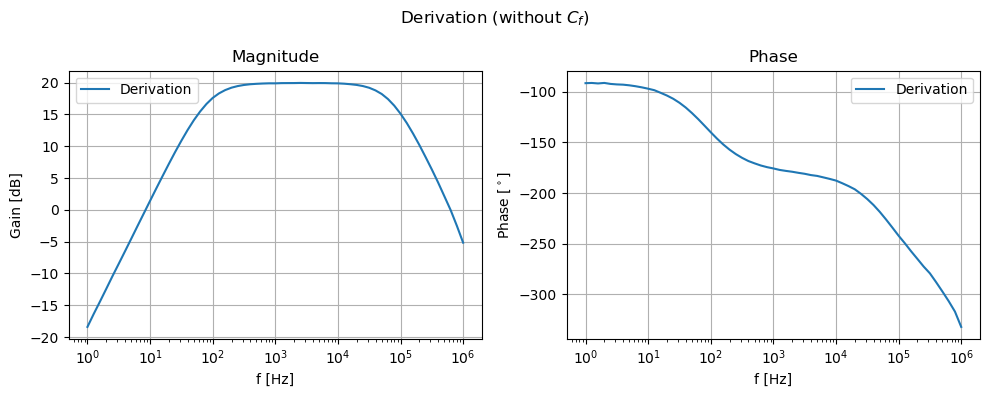

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("2_bode_derv_woutcf.csv", fig, axes, name="Derivation")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Derivation (without $C_f$)")
fig.tight_layout()

In [11]:
C1 = 24.33e-9
C2 = 21.88e-9


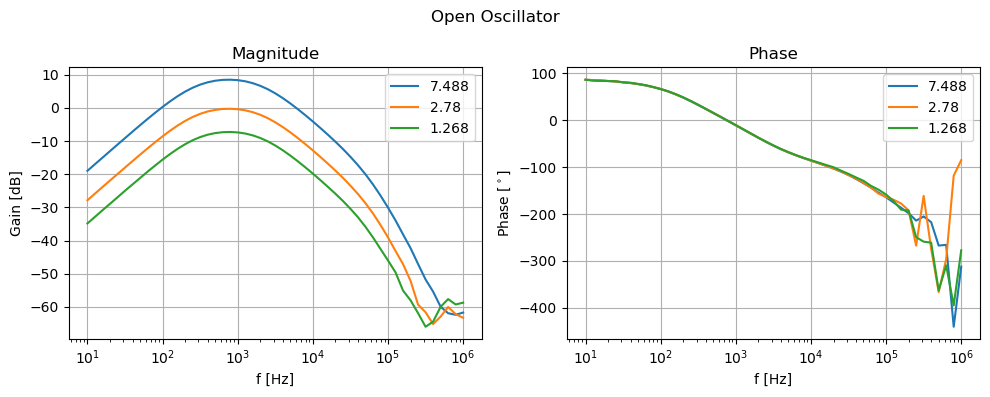

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("3_bode_7.488.csv", fig, axes, name="7.488")
plot_bode("3_bode_2.78.csv", fig, axes, name="2.78")
plot_bode("3_bode_1.268.csv", fig, axes, name="1.268")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Open Oscillator")
fig.tight_layout()

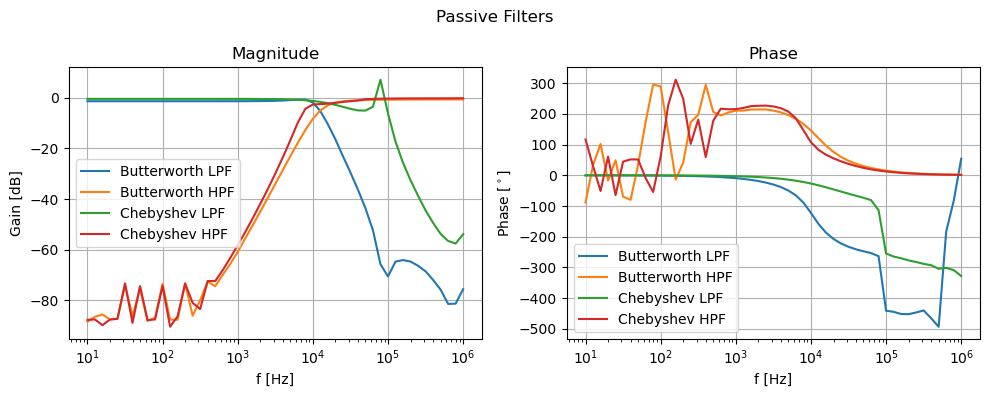

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_bode("4_bode_bw3lpf.csv", fig, axes, name="Butterworth LPF")
plot_bode("4_bode_bw3hpf.csv", fig, axes, name="Butterworth HPF")
plot_bode("4_bode_cheblpf.csv", fig, axes, name="Chebyshev LPF")
plot_bode("4_bode_chebhpf.csv", fig, axes, name="Chebyshev HPF")
axstgs[0].apply_axes(axes[0])
axstgs[1].apply_axes(axes[1])
fig.suptitle("Passive Filters")
fig.tight_layout()